In [1]:
import torch
from glob import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from torchvision.io import read_image
import numpy as np
import random
import os

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision.transforms.functional import pad
from torch.utils.data import random_split
import copy
from copy import deepcopy
from torch.optim.lr_scheduler import StepLR
from torch import amp
from tqdm import tqdm
import gc

import sys
sys.path.append("/kaggle/input/unetmodel-implementation")
from unet import UnetModel

# Configurations

In [2]:
#### Environment variables allow the accessing to the dataset without hardcoded paths, making it more flexible and portable. It also makes it easier to manage file locations in different environments (local, kaggle ...)####
os.environ['DATASET_IMGS_PATH'] = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/"
os.environ['DATASET_MASKS_PATH'] = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass/"

class Config:
    
    def __init__(self):

        ### Get the path from the environment variable ###
        self.imgs_base_path = os.environ.get('DATASET_IMGS_PATH')
        self.masks_base_path = os.environ.get('DATASET_MASKS_PATH')

        # Validate the paths
        if not os.path.exists(self.imgs_base_path):
            raise FileNotFoundError(f"Dataset imgs path not found: {self.imgs_base_path}")
        if not os.path.exists(self.masks_base_path):
            raise FileNotFoundError(f"Dataset masks path not found: {self.masks_base_path}")

        ### Since not all images have semantic masks, we need to extract only the images that do and split them into training, validation and test sets ###

        self.masks_path = sorted(glob(os.path.join(self.masks_base_path, "*")))
        self.indexes = [os.path.basename(i)[:-4] for i in self.masks_path]
        self.imgs_path = sorted([os.path.join(self.imgs_base_path, f"{i}.jpg") for i in self.indexes])
        
        self.train_masks_path, self.val_masks_path, self.test_masks_path = random_split(self.masks_path, [0.85, 0.11, 0.04]) 
        self.train_indexes, self.val_indexes, self.test_indexes = [os.path.basename(i)[:-4] for i in self.train_masks_path], [os.path.basename(i)[:-4] for i in self.val_masks_path], [os.path.basename(i)[:-4] for i in self.test_masks_path]
        self.train_imgs_path = [os.path.join(self.imgs_base_path, f"{i}.jpg") for i in self.train_indexes]
        self.val_imgs_path = [os.path.join(self.imgs_base_path, f"{i}.jpg") for i in self.val_indexes]
        self.test_imgs_path = [os.path.join(self.imgs_base_path, f"{i}.jpg") for i in self.test_indexes]

        self.classes = pd.DataFrame(columns=['rgb', 'key'])
        self.nbr_of_classes = 21

        
        self.seed = 10
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # torch.device("cpu") #
        print(self.device)
        self.lr = 0.001
        self.epochs = 30
        self.batch_size = 8

        
Config = Config()

cuda:0


In [3]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
### setting seeds to make the code reproductible ###

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')

set_seed(Config.seed)

> SEEDING DONE


# Data Exploration

In [4]:
def read_img_mask(index):
    img = cv2.imread(Config.imgs_path[index])
    mask = cv2.imread(Config.masks_path[index])
    return img, mask

def show_img_mask(img, mask):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img)
    axes[0].axis("off")
    
    axes[1].imshow(mask)
    axes[1].axis("off")
    
    plt.show()

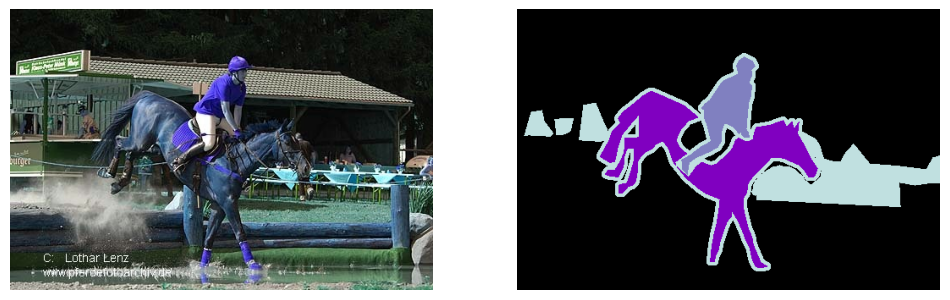

In [5]:
img = cv2.imread(Config.imgs_base_path+ '2007_000392.jpg')
mask = cv2.imread(Config.masks_base_path+ '2007_000392.png')
show_img_mask(img, mask)

In [6]:
## Get the RGB code of each class (20 unique rgbs), map it to an index from 1 to 20 + background

def get_rgb(index, classes):

    mask = cv2.imread(Config.masks_path[index])
    unique = np.unique(mask.reshape(-1, mask.shape[-1]), axis=0)
    
    for x in unique:
        color_tuple = tuple(x)
        
        if color_tuple != (0,0,0) and (not any(Config.classes['rgb'] == color_tuple)):
            new_row = pd.DataFrame({'rgb':[color_tuple], 'key':[len(Config.classes)]})
            Config.classes = pd.concat([Config.classes, new_row], ignore_index = True)
    
    
for index in range(0, len(Config.masks_path)):
    if len(Config.classes)<Config.nbr_of_classes:
        get_rgb(index, Config.classes) 
    else:
        break


print(all(pd.unique(Config.classes['rgb'])))

color_map = {row['key']: row['rgb'] for _, row in Config.classes.iterrows()}
print(color_map)

True
{0: (0, 0, 128), 1: (128, 128, 192), 2: (192, 224, 224), 3: (128, 64, 0), 4: (0, 192, 128), 5: (128, 0, 0), 6: (0, 0, 192), 7: (128, 0, 64), 8: (0, 128, 128), 9: (0, 128, 0), 10: (128, 0, 128), 11: (0, 64, 128), 12: (0, 128, 192), 13: (128, 0, 192), 14: (128, 128, 64), 15: (0, 192, 0), 16: (0, 128, 64), 17: (128, 128, 128), 18: (0, 0, 64), 19: (128, 128, 0), 20: (0, 64, 0)}


In [7]:
### Determine the maximum shape of image and mask to make them the same size (through padding to maximum shape) ###

def determine_img_mask_shape(index):
    img = cv2.imread(Config.imgs_path[index])
    mask = cv2.imread(Config.masks_path[index])
    return max(img.shape[0], mask.shape[0]), max(img.shape[1], mask.shape[1])

def determine_max_img_mask_shape():
    maxrows, maxcols = 0, 0
    for index in range(len(Config.imgs_path)):
        r, c = determine_img_mask_shape(index)
        maxrows, maxcols = max(maxrows, r), max(maxcols, c)
    return maxrows, maxcols

maxRows, maxCols = determine_max_img_mask_shape()

print(maxRows, maxCols)
### max shape is (500, 500) so we set it to 512 since powers of two take less computation to calculate ###

KeyboardInterrupt: 

# Defining the dataset and dataloaders

In [ ]:
class my_dataset(Dataset):
    def __init__(self, imgs_path, masks_path):
        self.imgs = imgs_path
        self.masks = masks_path

    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self, index):

        img, mask = read_img_mask(index)
        
        tmp = np.zeros((mask.shape[0], mask.shape[1], Config.nbr_of_classes), dtype=np.float32)

        for cls in range(Config.nbr_of_classes):
            tmp[:, :, cls] = np.all(mask == Config.classes.iloc[cls]['rgb'], axis=-1)
        
        img = torch.tensor(img, dtype=torch.float32)
        tmp = torch.tensor(tmp, dtype=torch.float32)

        classes_vector = torch.arange(Config.nbr_of_classes, dtype=torch.uint8).view(1, 1, -1)
        tmp = torch.sum(tmp * classes_vector, dim=-1)

        img = img.permute(2, 0, 1)

        pad_width, pad_height = max(0, 512-img.shape[-1]), max(0, 512-img.shape[-2])
        img = pad(img, padding=(pad_width,0 , 0, pad_height), fill=0, padding_mode='constant')
        tmp = pad(tmp, padding=(pad_width,0 , 0, pad_height), fill=0, padding_mode='constant')

        return img, tmp

In [ ]:
train_dataset = my_dataset(Config.train_imgs_path, Config.train_masks_path)
val_dataset = my_dataset(Config.val_imgs_path, Config.val_masks_path)
test_dataset = my_dataset(Config.test_imgs_path, Config.test_masks_path)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=True)

In [ ]:
### Testing the dataloaders: Fetch a batch from the dataloader to test it ###

train_batch = next(iter(train_dataloader)) 
train_images, train_labels = train_batch
print(f"Train batch - Images shape: {train_images.shape}, Labels shape: {train_labels.shape}")

# Defining the training

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler() # Helps scale gradients for improvd stability
    running_loss = 0.0
    dataset_size = 0
    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Train')
    
    for step, (images, masks) in pbar:

        images = images.to(device, dtype= torch.float)
        masks = masks.to(device, dtype=torch.long)

        batch_size = images.size(0)

        with amp.autocast(enabled=True, device_type=str(Config.device)): # context manager that mixes float16 adn float32 calculations to optimize performance, speedup, memory effciency
            y_pred = model(images)

            loss = criterion(y_pred, masks)
    
    
        scaler.scale(loss).backward() # prevents gradients over or under flows
        scaler.step(optimizer)
        scaler.update() 
        optimizer.zero_grad() # clears the accumulated gradients so that they don't interfere with the next pass
    
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
    
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0 # Monitor GPU memory usage, for optimizing training.
        current_lr = optimizer.param_groups[0]['lr'] # Extracts the current learning rate from the optimizer's parameter groups. Tracking dynamic learning rates when using schedulers
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', gpu_mem=f'{mem:0.2f} GB')
    
    
    scheduler.step()

    torch.cuda.empty_cache() # manage memory efficiently
    gc.collect() # manage memory efficiently

    return epoch_loss

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        

        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.long)


        batch_size = images.size(0)
        
        y_pred = model(images)
        
        loss = criterion(y_pred, masks)
        
        dataset_size += batch_size
        running_loss += (loss.item() * batch_size)
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}', gpu_memory=f'{mem:0.2f} GB')

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    model = model.to(device)
    for epoch in range(1, num_epochs + 1): 
        print(f'Epoch {epoch}/{num_epochs}', end='')

        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_dataloader, 
                                           device=device, epoch=epoch)
        
        val_loss = valid_one_epoch(model, val_dataloader, 
                                                 device=device, 
                                                 epoch=epoch)

# Training the Unet Model

In [ ]:
UNETmodel = UnetModel(in_channels=3, out_channels=Config.nbr_of_classes)

In [ ]:
optimizer = optim.Adam(UNETmodel.parameters(), lr=Config.lr)
scheduler = StepLR(optimizer, step_size=10) ### StepLR is to change the lr in each epoch not after each batch ###
criterion = nn.CrossEntropyLoss()

In [ ]:
run_training(UNETmodel, optimizer, scheduler, Config.device, Config.epochs)

last_model_wts = copy.deepcopy(UNETmodel.state_dict())
PATH = f"last_epoch.bin"
torch.save(UNETmodel.state_dict(), PATH)